In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from typing import Callable, Optional

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal
from causal_pyro.observational.handlers import CutModule, cut
from pyro.infer import Predictive

sns.set_style("white")

%load_ext nb_black

pyro.set_rng_seed(321) # for reproducibility

<IPython.core.display.Javascript object>

## Causal Effect Estimation: California Smoking Cessation Program

In 1989, California passed Proposition 99 which increased cigarette taxes. We will estimate the impact this policy had on cigarette consumption using the California smoking cessation program dataset [2]. This dataset consists of cigarette consumption of 39 states between 1970 to 2000, 38 of which are control units.

We start by loading and visualizing the dataset.

In [2]:
# Let's load the data from the author's github
DATA_URL = "https://raw.githubusercontent.com/synth-inference/synthdid/master/data/california_prop99.csv"
data = pd.read_csv(DATA_URL, sep=";")

# Assign unique integer ids for each state and each time
data["unit_index"] = pd.factorize(data["State"].values)[0]
data["time_index"] = pd.factorize(data["Year"].values)[0]

# Model below assumes the response is coded as "y"
data["y"] = data["PacksPerCapita"].values.copy()

# Assign each unit to treatment or control group
data["in_treatment_group"] = 0
treated_units = data[data["treated"] == 1]["State"].unique()
data.loc[data["State"].isin(treated_units), "in_treatment_group"] = 1

<IPython.core.display.Javascript object>

In [3]:
# Show first few rows of the dataset
data.head()

,State,Year,PacksPerCapita,treated,unit_index,time_index,y,in_treatment_group
0,Alabama,1970,89.800003,0,0,0,89.800003,0
1,Arkansas,1970,100.300003,0,1,0,100.300003,0
2,Colorado,1970,124.800003,0,2,0,124.800003,0
3,Connecticut,1970,120.000000,0,3,0,120.000000,0
4,Delaware,1970,155.000000,0,4,0,155.000000,0


<IPython.core.display.Javascript object>

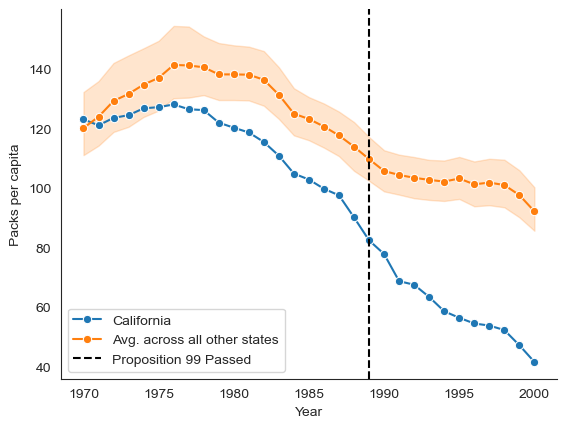

<IPython.core.display.Javascript object>

In [4]:
sns.lineplot(
    x=data[data["State"] == "California"]["Year"],
    y=data[data["State"] == "California"]["PacksPerCapita"],
    marker="o",
    label='California',
)

# The shaded area is the plot is the 95% confidence interval around the mean
sns.lineplot(
    x=data[data["State"] != "California"]["Year"],
    y=data[data["State"] != "California"]["PacksPerCapita"],
    marker="o",
    label='Avg. across all other states',
)

plt.axvline(
    1989, label="Proposition 99 Passed", color="black", linestyle="dashed"
)
plt.ylabel("Packs per capita")
sns.despine()
plt.legend()

### We would like to estimate a counterfactual: had California not raised cigarette taxes, what would have cigarette consumption been?

To estimate this effect, we implement a Bayesian analogue of the Synthetic Difference-in-Differences (SDID) estimator proposed in [1]. 

In [5]:
class BayesSDID(pyro.nn.PyroModule):
    def __init__(self, X: pd.DataFrame):
        """
        Input:
            X: dataframe with columns "unit_index", "time_index", "in_treatment_group", "y", "treated"
        """
        super().__init__()
        self.X = X.copy() # TODO: sort as necessary
        units_by_group = X[["unit_index", "in_treatment_group"]].drop_duplicates()
        self.N = units_by_group.shape[0] # number of units
        self.N_tr = units_by_group["in_treatment_group"].sum()  # number of treated units
        self.N_co = self.N - self.N_tr  # number of control units
        self.T_pre = X[X["treated"] == 1]["time_index"].min()  # number of pre-treatment periods
        self.T_post = data["time_index"].max() - self.T_pre + 1  # number of post-treatment periods
        self.T = self.T_pre + self.T_post  # total number of periods
        self.times_by_units = torch.tensor(pd.pivot_table(X, values="y", index="time_index", columns="unit_index").values).float()
        self.avg_y_post_treat = self.times_by_units[self.T_pre:, self.N_co:].mean(axis=0)  # average of each treated unit over the post-treatment period
        self.y_pre_treat_tr_avg = self.times_by_units[:self.T_pre, self.N_co:].mean(axis=1)
        self.y = torch.tensor(X["y"].values)
        self.treated = torch.tensor(data["treated"].values)
        self.unit_index = list(X["unit_index"].values)
        self.time_index = list(X["time_index"].values)

    def sample_synthetic_control_weights(self):
        w0 = pyro.sample("w0", dist.Normal(0, 1)) # intercept
        w_co = pyro.sample("w_co", dist.Dirichlet(torch.ones(self.N_co))) # convex combination of control units
        return w0, w_co
    
    def sample_time_weights(self):
        lam_0 = pyro.sample("lam_0", dist.Normal(0, 1)) # intercept
        lam_pre = pyro.sample("lam_pre", dist.Dirichlet(torch.ones(self.T_pre))) # convex combination of time periods
        return lam_0, lam_pre

    def sample_response_params(self, prior_scale=10):
        # Intercept, time fixed effects, treatment effect, unit fixed effects 
        mu = pyro.sample("mu", dist.Normal(0, prior_scale))
        beta = pyro.sample("beta", dist.Normal(0, prior_scale).expand((self.T,)).to_event(1))
        tau = pyro.sample("tau", dist.Normal(0, prior_scale))
        alpha = pyro.sample( "alpha", dist.Normal(0, prior_scale).expand((self.N,)).to_event(1))
        return mu, beta, tau, alpha
    
    def synthetic_control_unit(self, times_by_units: torch.Tensor, w0: torch.Tensor, w_co: torch.Tensor):
        return w0 + times_by_units.mv(w_co)
            
    def time_control(self, units_by_time: torch.Tensor, lam_0, lam_pre):
        return lam_0 + units_by_time.mv(lam_pre)

    def forward(self, **kwargs):        
        # Sample synthetic control weights, time weights, response parameters
        w0, w_co = self.sample_synthetic_control_weights()
        w_co_tr = torch.cat([w_co, 1 / self.N_tr * torch.ones(self.N_tr)]) # TODO: this assumes
        lam_0, lam_pre = self.sample_time_weights()
        lam_pre_post = torch.cat([lam_pre, 1 / self.T_post * torch.ones(self.T_post)]) # TODO: this assumes
        mu, beta, tau, alpha = self.sample_response_params(**kwargs)
        
        # Synthetic control weights likelihood
        y_sc = self.synthetic_control_unit(self.times_by_units[:self.T_pre, :self.N_co], w0, w_co)
        with pyro.plate("synthetic_control_weights", self.T_pre):
            pyro.sample("y_pre_treat_tr_avg", dist.Normal(y_sc, 1.0), obs=self.y_pre_treat_tr_avg)

        # Time weights likelihood
        y_time = self.time_control(self.times_by_units[:self.T_pre, :].T, lam_0, lam_pre)
        with pyro.plate("time_weights", self.N):
            pyro.sample("avg_y_post_treat", dist.Normal(y_time, 1.0), obs=self.avg_y_post_treat)

        # Response likelihood
        weights = w_co_tr[self.unit_index] * lam_pre_post[self.time_index]
        f = mu + beta[self.time_index] + alpha[self.unit_index] + tau * self.treated
        with pyro.plate("response", self.N * self.T):
            pyro.sample("y", dist.Normal(f, 1 / weights), obs=self.y)


<IPython.core.display.Javascript object>

### Let's visualize our Bayesian SDID probabilistic model.

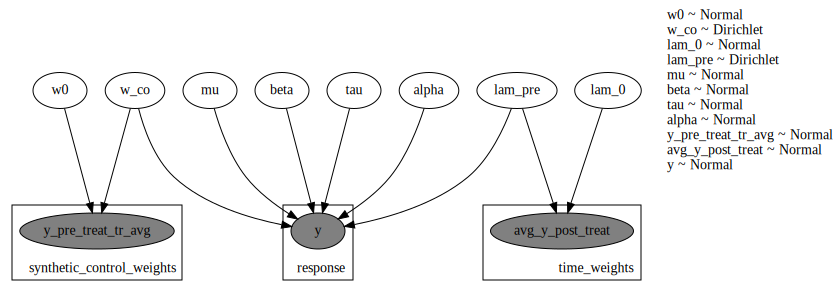

<IPython.core.display.Javascript object>

In [6]:
pyro.render_model(BayesSDID(data), render_params=True, render_distributions=True)

### First, we consider estimating $\tau$ by performing joint Bayesian inference over all latents in the model. We report the marginal approximate posterior over $\tau$

In [7]:
# Define a helper function to run SVI. (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(
    model: Callable, vi_family: Optional[Callable] = None, guide: Optional[Callable] = None, n_steps=100, verbose=True, **model_kwargs
):
    if guide is None:
        guide = vi_family(model)
    adam = pyro.optim.Adam({"lr": 0.03})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    # Do gradient steps
    pyro.clear_param_store()
    for step in range(1, n_steps + 1):
        loss = svi.step(**model_kwargs)
        if (step % 100 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))

    return guide

<IPython.core.display.Javascript object>

In [8]:
joint_guide = run_svi_inference(BayesSDID(data), vi_family=AutoMultivariateNormal, n_steps=2500)

# Get posterior samples from the joint guide
joint_samples = Predictive(BayesSDID(data), guide=joint_guide, num_samples=1000)()

[iteration 0001] loss: 125027.7949
[iteration 0100] loss: 81168.0744
[iteration 0200] loss: 71382.6594
[iteration 0300] loss: 64230.2687
[iteration 0400] loss: 59799.1972
[iteration 0500] loss: 55700.9109
[iteration 0600] loss: 51567.2786
[iteration 0700] loss: 48039.8348
[iteration 0800] loss: 44809.3625
[iteration 0900] loss: 42277.5765
[iteration 1000] loss: 39655.9898
[iteration 1100] loss: 37290.7595
[iteration 1200] loss: 35094.0847
[iteration 1300] loss: 33938.4114
[iteration 1400] loss: 31941.9784
[iteration 1500] loss: 30695.9916
[iteration 1600] loss: 29557.7725
[iteration 1700] loss: 28751.1535
[iteration 1800] loss: 27814.4378
[iteration 1900] loss: 27087.9322
[iteration 2000] loss: 26385.5582
[iteration 2100] loss: 25841.7206
[iteration 2200] loss: 25448.4154
[iteration 2300] loss: 25024.3135
[iteration 2400] loss: 24675.8681
[iteration 2500] loss: 24467.5601


<IPython.core.display.Javascript object>

Text(0.5, 0, '$\\tau$')

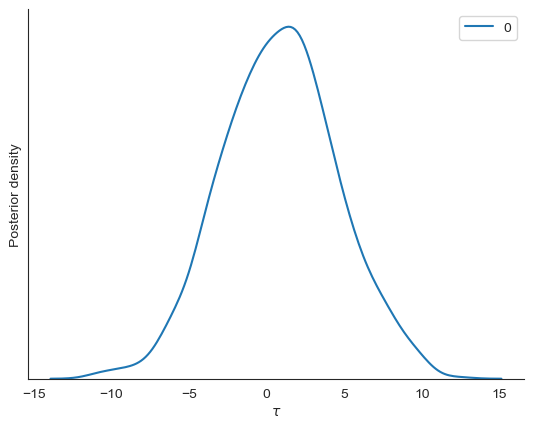

<IPython.core.display.Javascript object>

In [9]:
sns.kdeplot(joint_samples["tau"])
sns.despine()
plt.yticks([])
plt.ylabel("Posterior density")
plt.xlabel("$\\tau$")

In [10]:
# Check synthetic control weights

<IPython.core.display.Javascript object>

### We use modular Bayesian inference to robustify our estimates to model misspecification. We define "module one" to consist of all observed and latent variables associated with the time and synthetic control weights. We define "module two" as t

The response likelihood is likely misspecified. To prevent this misspecification from messing up the estimates of the synthetic control weights, we use modular Bayesian inference. 

Specifically, we.....

CITE CUT VI PAPERS

In [11]:
def cut_guide_wrapper(module_one_guide, module_two_guide):
    def cut_guide():
        with pyro.poutine.trace() as module_one_tr:
            module_one_guide()
        module_one_guide.requires_grad_(False) # freeze module one parameters
        module_two_guide(module_one_tr)
    return cut_guide


def cut_svi_inference(model, module_one_vars, vi_family_one, vi_family_two, **kwargs):
    module_one, module_two = cut(model=model, vars=module_one_vars)

    # Hack to get around Pyro's potential naming conflict when using
    # the same type of Autoguide for each module
    guides = pyro.nn.PyroModule()
    guides.module_one = vi_family_one(module_one)
    
    # Fit module one 
    module_one_guide = run_svi_inference(module_one, guide=guides.module_one, **kwargs)
    
    # Define guide for module two conditioned on module one, i.e. q(module_two latents | module_one latents)
    def module_two_cond_guide(module_one_tr, **kwargs):
        latent_names = [name for name, msg in module_one_tr.trace.nodes.items() if not msg['is_observed']]
        latent_names = [name for name in latent_names if name in module_one_vars]
        module_one_latents = dict([(name, module_one_tr.trace.nodes[name]["value"]) for name in latent_names])
        module_two_cond = pyro.condition(module_two, data=module_one_latents)
        vi_family_two(module_two_cond, **kwargs)()

    # Fit cut posterior
    cut_guide = cut_guide_wrapper(module_one_guide, module_two_cond_guide)
    cut_guide = run_svi_inference(model, guide=cut_guide, **kwargs)
    return cut_guide
 

<IPython.core.display.Javascript object>

In [12]:
module_one_vars = ["w0", "w_co", "y_pre_treat_tr_avg", "lam_0", "lam_pre", "avg_y_post_treat"]

cut_guide = cut_svi_inference(
                BayesSDID(data), module_one_vars, 
                vi_family_one=AutoMultivariateNormal, 
                vi_family_two=AutoMultivariateNormal, n_steps=2500
            )

cut_samples = Predictive(BayesSDID(data), guide=cut_guide, num_samples=1000)()

[iteration 0001] loss: 115559.6882
[iteration 0100] loss: 69588.7365
[iteration 0200] loss: 58171.4921
[iteration 0300] loss: 51130.2981
[iteration 0400] loss: 45743.7669
[iteration 0500] loss: 42995.3191
[iteration 0600] loss: 41336.8050
[iteration 0700] loss: 37978.5677
[iteration 0800] loss: 33743.0396
[iteration 0900] loss: 30974.9198
[iteration 1000] loss: 27754.0392
[iteration 1100] loss: 25134.5731
[iteration 1200] loss: 22500.5245
[iteration 1300] loss: 21551.2035
[iteration 1400] loss: 20929.9636
[iteration 1500] loss: 19129.1185
[iteration 1600] loss: 18613.2033
[iteration 1700] loss: 17227.8527
[iteration 1800] loss: 16220.3654
[iteration 1900] loss: 15726.4397
[iteration 2000] loss: 15545.1979
[iteration 2100] loss: 14595.4113
[iteration 2200] loss: 14495.1296
[iteration 2300] loss: 14054.2087
[iteration 2400] loss: 13977.1039
[iteration 2500] loss: 13829.4089
[iteration 0001] loss: 34176.3318


/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'alpha_nuisance', 'mu_nuisance', 'tau_nuisance', 'beta_nuisance'}
  warnings.warn(


[iteration 0100] loss: 32516.2119
[iteration 0200] loss: 31875.7697
[iteration 0300] loss: 30593.1847
[iteration 0400] loss: 30414.9588
[iteration 0500] loss: 29545.1071
[iteration 0600] loss: 29823.7667
[iteration 0700] loss: 29424.0688
[iteration 0800] loss: 30209.5975
[iteration 0900] loss: 29053.4849
[iteration 1000] loss: 28324.1964
[iteration 1100] loss: 28542.6418
[iteration 1200] loss: 28286.0707
[iteration 1300] loss: 27740.1455
[iteration 1400] loss: 27776.7195
[iteration 1500] loss: 27972.8444
[iteration 1600] loss: 27899.7438
[iteration 1700] loss: 28031.6697
[iteration 1800] loss: 27786.6602
[iteration 1900] loss: 27982.0634
[iteration 2000] loss: 27560.0684
[iteration 2100] loss: 28769.8839
[iteration 2200] loss: 28131.4267
[iteration 2300] loss: 27811.5728
[iteration 2400] loss: 28183.8543
[iteration 2500] loss: 27612.3179


<IPython.core.display.Javascript object>

Text(0.5, 0, '$\\tau$')

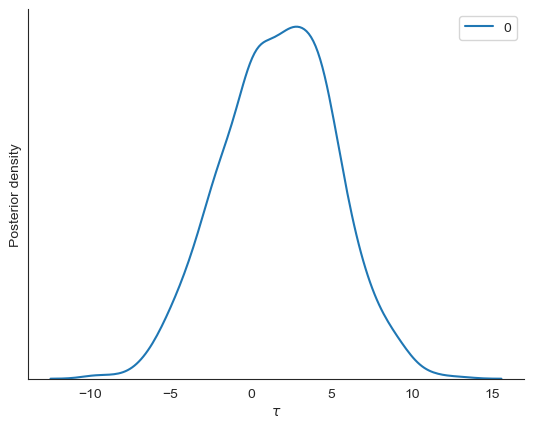

<IPython.core.display.Javascript object>

In [14]:
sns.kdeplot(cut_samples["tau"])
sns.despine()
plt.yticks([])
plt.ylabel("Posterior density")
plt.xlabel("$\\tau$")

# References
1. https://www.aeaweb.org/articles?id=10.1257/aer.20190159
2. https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746